In [55]:
#Environment setup
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
#libraries loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [56]:
data_ltc = pd.read_csv("LTC-USD.csv")# Data loading


data_ltc.head()#data viewing

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840,ltc_usd
1,2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260,ltc_usd
2,2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450,ltc_usd
3,2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660,ltc_usd
4,2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220,ltc_usd


In [57]:
data_ltc['Close'].value_counts() 

3.786810     2
2.844650     2
1.786460     2
5.058550     1
75.535622    1
            ..
30.220100    1
35.700500    1
47.645901    1
46.041599    1
62.754936    1
Name: Close, Length: 2984, dtype: int64

In [58]:
df = data_ltc.loc[(data_ltc['key'] == 'ltc_usd')]
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,key
0,2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840,ltc_usd
1,2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260,ltc_usd
2,2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450,ltc_usd
3,2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660,ltc_usd
4,2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220,ltc_usd
5,2014-09-22,4.24593,4.41688,4.21013,4.24235,4.24235,1855960,ltc_usd
6,2014-09-23,4.23999,4.88135,4.18887,4.74657,4.74657,4661670,ltc_usd
7,2014-09-24,4.74420,4.74512,4.62769,4.66679,4.66679,2662290,ltc_usd
8,2014-09-25,4.66588,4.67132,4.44870,4.51465,4.51465,2046960,ltc_usd
9,2014-09-26,4.50993,4.55182,4.38880,4.43359,4.43359,1548350,ltc_usd


In [59]:
#date time collection
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.loc[df['Date'] > pd.to_datetime('2014-09-17')]

In [60]:
df = df[['Date','Open','Close','High','Low','Volume']]

In [61]:
df.head()

,Date,Open,Close,High,Low,Volume
1,2014-09-18,5.06543,4.68523,5.06543,4.57996,4569260
2,2014-09-19,4.68729,4.32777,4.75582,4.25435,3917450
3,2014-09-20,4.32920,4.28644,4.61608,4.20219,5490660
4,2014-09-21,4.26307,4.24592,4.30013,4.15499,2931220
5,2014-09-22,4.24593,4.24235,4.41688,4.21013,1855960


In [62]:
df = df[['Close']]

In [63]:
dataset = df.values
dataset = dataset.astype('float32')

In [64]:
dataset

array([[ 4.68523 ],
       [ 4.32777 ],
       [ 4.28644 ],
       ...,
       [62.643764],
       [63.812397],
       [62.754936]], dtype=float32)

In [65]:
#Rescaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scale = scaler.fit_transform(dataset)

In [66]:
dataset_scale

array([[0.00915722],
       [0.00822946],
       [0.00812219],
       ...,
       [0.1595841 ],
       [0.16261719],
       [0.15987264]], dtype=float32)

In [67]:
#training set size
train_size = int(len(dataset_scale) * 0.709)
test_size = len(dataset_scale) - train_size
train, test = dataset_scale[0:train_size, :], dataset_scale[train_size:len(dataset), :]
print(len(train), len(test))

2117 869


In [68]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [69]:
look_back = 20
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [70]:
trainX
trainY
#testX
#testY

array([0.0071397 , 0.00712093, 0.00687886, ..., 0.10522423, 0.10467007,
       0.1039418 ], dtype=float32)

In [71]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [72]:
#Model set-up
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adam')
model.fit(trainX, trainY, epochs=500, batch_size=300, verbose=2)

Epoch 1/600
6/6 - 1s - loss: 0.0535 - 786ms/epoch - 131ms/step
Epoch 2/600
6/6 - 0s - loss: 0.0422 - 9ms/epoch - 1ms/step
Epoch 3/600
6/6 - 0s - loss: 0.0322 - 9ms/epoch - 2ms/step
Epoch 4/600
6/6 - 0s - loss: 0.0242 - 10ms/epoch - 2ms/step
Epoch 5/600
6/6 - 0s - loss: 0.0176 - 11ms/epoch - 2ms/step
Epoch 6/600
6/6 - 0s - loss: 0.0128 - 10ms/epoch - 2ms/step
Epoch 7/600
6/6 - 0s - loss: 0.0091 - 9ms/epoch - 2ms/step
Epoch 8/600
6/6 - 0s - loss: 0.0068 - 10ms/epoch - 2ms/step
Epoch 9/600
6/6 - 0s - loss: 0.0053 - 9ms/epoch - 2ms/step
Epoch 10/600
6/6 - 0s - loss: 0.0043 - 10ms/epoch - 2ms/step
Epoch 11/600
6/6 - 0s - loss: 0.0038 - 11ms/epoch - 2ms/step
Epoch 12/600
6/6 - 0s - loss: 0.0034 - 11ms/epoch - 2ms/step
Epoch 13/600
6/6 - 0s - loss: 0.0031 - 9ms/epoch - 2ms/step
Epoch 14/600
6/6 - 0s - loss: 0.0028 - 11ms/epoch - 2ms/step
Epoch 15/600
6/6 - 0s - loss: 0.0026 - 10ms/epoch - 2ms/step
Epoch 16/600
6/6 - 0s - loss: 0.0024 - 10ms/epoch - 2ms/step
Epoch 17/600
6/6 - 0s - loss: 0.002

Epoch 131/600
6/6 - 0s - loss: 5.6736e-04 - 11ms/epoch - 2ms/step
Epoch 132/600
6/6 - 0s - loss: 5.6474e-04 - 10ms/epoch - 2ms/step
Epoch 133/600
6/6 - 0s - loss: 5.6207e-04 - 10ms/epoch - 2ms/step
Epoch 134/600
6/6 - 0s - loss: 5.5924e-04 - 10ms/epoch - 2ms/step
Epoch 135/600
6/6 - 0s - loss: 5.5701e-04 - 9ms/epoch - 2ms/step
Epoch 136/600
6/6 - 0s - loss: 5.5407e-04 - 11ms/epoch - 2ms/step
Epoch 137/600
6/6 - 0s - loss: 5.5156e-04 - 10ms/epoch - 2ms/step
Epoch 138/600
6/6 - 0s - loss: 5.5018e-04 - 9ms/epoch - 2ms/step
Epoch 139/600
6/6 - 0s - loss: 5.4702e-04 - 10ms/epoch - 2ms/step
Epoch 140/600
6/6 - 0s - loss: 5.4512e-04 - 10ms/epoch - 2ms/step
Epoch 141/600
6/6 - 0s - loss: 5.4345e-04 - 9ms/epoch - 2ms/step
Epoch 142/600
6/6 - 0s - loss: 5.4101e-04 - 10ms/epoch - 2ms/step
Epoch 143/600
6/6 - 0s - loss: 5.3839e-04 - 10ms/epoch - 2ms/step
Epoch 144/600
6/6 - 0s - loss: 5.3568e-04 - 10ms/epoch - 2ms/step
Epoch 145/600
6/6 - 0s - loss: 5.3338e-04 - 11ms/epoch - 2ms/step
Epoch 146/600

Epoch 256/600
6/6 - 0s - loss: 3.7899e-04 - 9ms/epoch - 2ms/step
Epoch 257/600
6/6 - 0s - loss: 3.7772e-04 - 10ms/epoch - 2ms/step
Epoch 258/600
6/6 - 0s - loss: 3.7708e-04 - 10ms/epoch - 2ms/step
Epoch 259/600
6/6 - 0s - loss: 3.7700e-04 - 9ms/epoch - 2ms/step
Epoch 260/600
6/6 - 0s - loss: 3.7539e-04 - 10ms/epoch - 2ms/step
Epoch 261/600
6/6 - 0s - loss: 3.7465e-04 - 10ms/epoch - 2ms/step
Epoch 262/600
6/6 - 0s - loss: 3.7347e-04 - 9ms/epoch - 1ms/step
Epoch 263/600
6/6 - 0s - loss: 3.7215e-04 - 10ms/epoch - 2ms/step
Epoch 264/600
6/6 - 0s - loss: 3.7152e-04 - 10ms/epoch - 2ms/step
Epoch 265/600
6/6 - 0s - loss: 3.7024e-04 - 9ms/epoch - 2ms/step
Epoch 266/600
6/6 - 0s - loss: 3.6948e-04 - 10ms/epoch - 2ms/step
Epoch 267/600
6/6 - 0s - loss: 3.6865e-04 - 11ms/epoch - 2ms/step
Epoch 268/600
6/6 - 0s - loss: 3.6742e-04 - 11ms/epoch - 2ms/step
Epoch 269/600
6/6 - 0s - loss: 3.6634e-04 - 11ms/epoch - 2ms/step
Epoch 270/600
6/6 - 0s - loss: 3.6542e-04 - 10ms/epoch - 2ms/step
Epoch 271/600


Epoch 381/600
6/6 - 0s - loss: 2.9344e-04 - 10ms/epoch - 2ms/step
Epoch 382/600
6/6 - 0s - loss: 2.9301e-04 - 10ms/epoch - 2ms/step
Epoch 383/600
6/6 - 0s - loss: 2.9386e-04 - 9ms/epoch - 2ms/step
Epoch 384/600
6/6 - 0s - loss: 2.9347e-04 - 10ms/epoch - 2ms/step
Epoch 385/600
6/6 - 0s - loss: 2.9102e-04 - 9ms/epoch - 2ms/step
Epoch 386/600
6/6 - 0s - loss: 2.9085e-04 - 9ms/epoch - 2ms/step
Epoch 387/600
6/6 - 0s - loss: 2.9060e-04 - 10ms/epoch - 2ms/step
Epoch 388/600
6/6 - 0s - loss: 2.9043e-04 - 9ms/epoch - 2ms/step
Epoch 389/600
6/6 - 0s - loss: 2.8976e-04 - 9ms/epoch - 2ms/step
Epoch 390/600
6/6 - 0s - loss: 2.8915e-04 - 10ms/epoch - 2ms/step
Epoch 391/600
6/6 - 0s - loss: 2.8838e-04 - 9ms/epoch - 2ms/step
Epoch 392/600
6/6 - 0s - loss: 2.8815e-04 - 10ms/epoch - 2ms/step
Epoch 393/600
6/6 - 0s - loss: 2.8818e-04 - 10ms/epoch - 2ms/step
Epoch 394/600
6/6 - 0s - loss: 2.8784e-04 - 9ms/epoch - 2ms/step
Epoch 395/600
6/6 - 0s - loss: 2.8913e-04 - 10ms/epoch - 2ms/step
Epoch 396/600
6/6

Epoch 506/600
6/6 - 0s - loss: 2.5179e-04 - 9ms/epoch - 2ms/step
Epoch 507/600
6/6 - 0s - loss: 2.4961e-04 - 10ms/epoch - 2ms/step
Epoch 508/600
6/6 - 0s - loss: 2.5205e-04 - 10ms/epoch - 2ms/step
Epoch 509/600
6/6 - 0s - loss: 2.4979e-04 - 9ms/epoch - 2ms/step
Epoch 510/600
6/6 - 0s - loss: 2.5330e-04 - 10ms/epoch - 2ms/step
Epoch 511/600
6/6 - 0s - loss: 2.4902e-04 - 10ms/epoch - 2ms/step
Epoch 512/600
6/6 - 0s - loss: 2.4970e-04 - 9ms/epoch - 2ms/step
Epoch 513/600
6/6 - 0s - loss: 2.4898e-04 - 10ms/epoch - 2ms/step
Epoch 514/600
6/6 - 0s - loss: 2.5062e-04 - 10ms/epoch - 2ms/step
Epoch 515/600
6/6 - 0s - loss: 2.4910e-04 - 10ms/epoch - 2ms/step
Epoch 516/600
6/6 - 0s - loss: 2.5182e-04 - 10ms/epoch - 2ms/step
Epoch 517/600
6/6 - 0s - loss: 2.4795e-04 - 10ms/epoch - 2ms/step
Epoch 518/600
6/6 - 0s - loss: 2.4756e-04 - 9ms/epoch - 2ms/step
Epoch 519/600
6/6 - 0s - loss: 2.5141e-04 - 10ms/epoch - 2ms/step
Epoch 520/600
6/6 - 0s - loss: 2.4931e-04 - 10ms/epoch - 2ms/step
Epoch 521/600


In [73]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

27/27 [==============================] - 0s 752us/step


In [74]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [75]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.90 RMSE
Test Score: 10.44 RMSE


In [76]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [77]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

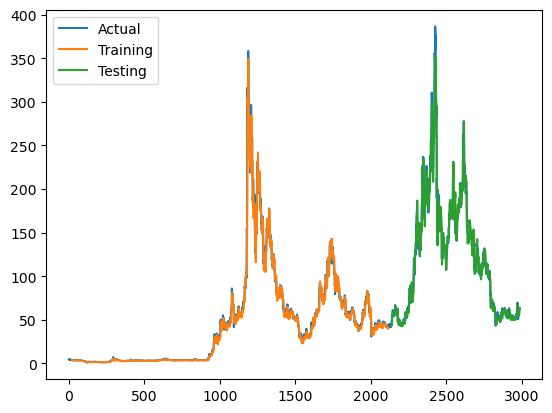

In [78]:
plt.plot(df['Close'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()

In [80]:
from sklearn.metrics import mean_squared_error

mean_squared_error(testY[0].reshape(-1),testPredict[:, 0])



109.05650315717381

In [81]:
    from keras.models import load_model
    model.save('ltc-adam.h5') 
    model.save_weights('ltc-adam_weights.h5')  # to store